In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf
import pandas as pd
import math
import datetime
# from tensorflow.keras import regularizers
# import tensorflow as tf
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
from keras.optimizers import Adam
from keras.layers import LSTM,Dense
from tensorflow.keras import regularizers,Sequential
%matplotlib inline
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

2023-08-22 17:27:26.866501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df=pd.read_csv('tezcatli_order_data.csv')

In [4]:
df

,Order Create Date,Region Name,forecast_group,Order Volume (STD)
0,3/30/13,Carolinas,C+ St Plk,3093.75
1,4/1/13,Canada East,C+ St Batt,216.00
2,4/1/13,Canada East,C+ St Batt,432.00
3,4/1/13,Canada East,C+ St HTG,406.64
4,4/1/13,Canada East,C+ St NT3,1296.00
...,...,...,...,...
3968008,7/31/23,Texas and South Plains,Pr Soff 12',3840.00
3968009,7/31/23,Texas and South Plains,Pr Soff 12',1920.00
3968010,7/31/23,Texas and South Plains,Pr Soff 12',7680.00
3968011,7/31/23,Texas and South Plains,Pr Soff 8',20480.00


In [7]:
df1=df.loc[(df['Region Name']=='Carolinas') & (df['forecast_group']=='C+ St Plk')]

In [8]:
df1.reset_index(inplace=True)

In [9]:
df1.drop('index',axis=1,inplace=True)

/tmp/ipykernel_8416/2513786180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop('index',axis=1,inplace=True)


In [10]:
df1['Order Create Date']=pd.to_datetime(df1['Order Create Date'])

/tmp/ipykernel_8416/3758666745.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Order Create Date']=pd.to_datetime(df1['Order Create Date'])


In [11]:
df2=df1.sort_values(by='Order Create Date')

In [12]:
df2.reset_index(inplace=True,drop=True)

In [13]:
# Extract year and month columns
df3=df2
df3['year'] = df3['Order Create Date'].dt.year
df3['month'] = df3['Order Create Date'].dt.month

# Group by year and month, then calculate the sum of 'quantity' column
result = df3.groupby(['year', 'month'])['Order Volume (STD)'].sum().reset_index()

In [14]:
df4=result

In [15]:
result['date']=result['year'].astype('string')+'-'+result['month'].astype('string')+'-01'
result.set_index('date',inplace=True)
result=result.drop(['year','month'],axis=1)
df4=result

<Axes: xlabel='date'>

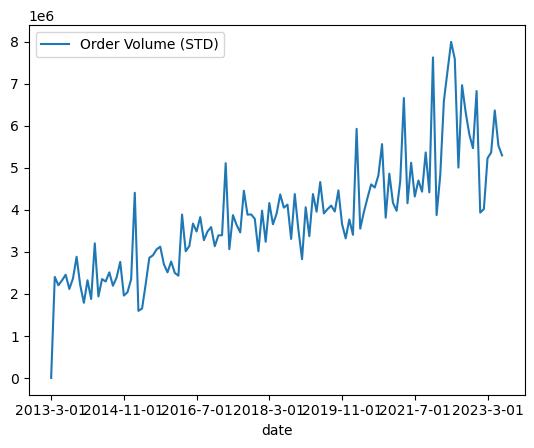

In [16]:
df4.plot()

In [17]:
def to_sequences(df, seq_size):
    """
    Convert a DataFrame into input (x) and output (y) sequences for a time series prediction task.

    Parameters:
        df (DataFrame): The input DataFrame containing time series data.
        seq_size (int): The size of the input sequences (window size). Default is 1.

    Returns:
        x (numpy.array): A 3D numpy array of shape (num_samples, seq_size, num_features).
                         It contains the input sequences used for prediction.
        y (numpy.array): A 1D numpy array containing the target values corresponding to each input sequence.
    """

    x = []  # List to store the input sequences (windows)
    y = []  # List to store the output values (targets)

    for i in range(len(df) - seq_size - 1):
        # Extract the current window (input sequence) from the DataFrame
        window = df[i:(i + seq_size), 0]
        x.append(window)

        # Get the target value corresponding to the next time step after the input sequence
        y.append(df[i + seq_size, 0])

    # Convert the lists to numpy arrays for further processing
    return np.array(x), np.array(y)


In [70]:
df5=df4.values
train_size=int(len(df5) * 1)
# test_size=len(df5) - train_size
train=df5

In [72]:
seq_size=40 # 45
trainX,trainY=to_sequences(train,seq_size)
trainX=np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
# LSTM model
model=Sequential()
model.add(LSTM(64,input_shape=(None,seq_size)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_absolute_error',optimizer=Adam(lr=0.28)) # 0.28
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                26880     
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 28,993
Trainable params: 28,993
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.fit(trainX,trainY,verbose=1,epochs=250)

Epoch 1/250
3/3 [==============================] - 1s 4ms/step - loss: 4485621.5000
Epoch 2/250
3/3 [==============================] - 0s 5ms/step - loss: 4485298.5000
Epoch 3/250
3/3 [==============================] - 0s 3ms/step - loss: 4484535.0000
Epoch 4/250
3/3 [==============================] - 0s 6ms/step - loss: 4483254.0000
Epoch 5/250
3/3 [==============================] - 0s 4ms/step - loss: 4481412.5000
Epoch 6/250
3/3 [==============================] - 0s 4ms/step - loss: 4478907.5000
Epoch 7/250
3/3 [==============================] - 0s 7ms/step - loss: 4475681.0000
Epoch 8/250
3/3 [==============================] - 0s 5ms/step - loss: 4471684.5000
Epoch 9/250
3/3 [==============================] - 0s 6ms/step - loss: 4466832.0000
Epoch 10/250
3/3 [==============================] - 0s 15ms/step - loss: 4461077.5000
Epoch 11/250
3/3 [==============================] - 0s 6ms/step - loss: 4454362.0000
Epoch 12/250
3/3 [==============================] - 0s 8ms/step - loss: 4

In [61]:
trainPredict=model.predict(trainX)

3/3 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Actual VS Predicted')

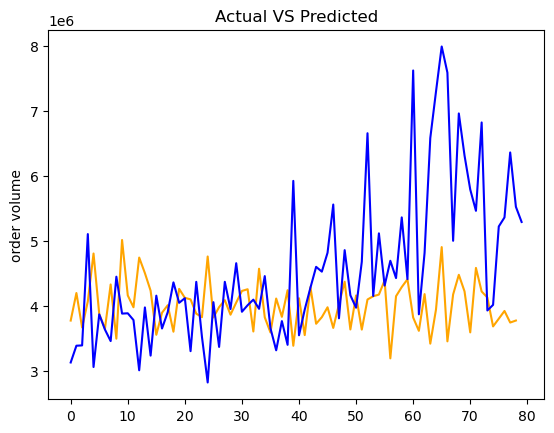

In [62]:
# Prediction on training
plt.plot(trainPredict[:],color='orange')
plt.plot(df4.values[seq_size:],color='blue')
plt.ylabel('order volume')
plt.title('Actual VS Predicted')

Text(0.5, 1.0, 'Actual VS Predicted')

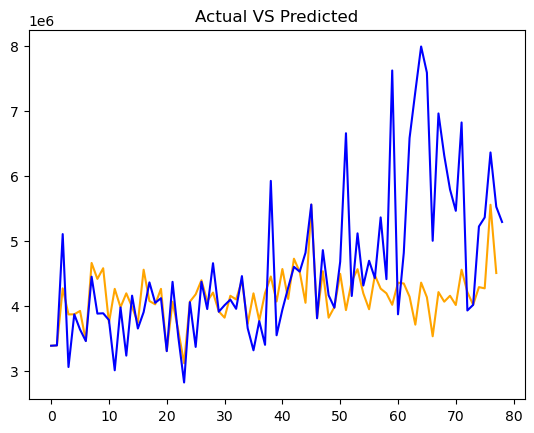

In [117]:
# Prediction on training
plt.plot(trainPredict[:],color='orange')
plt.plot(df4.values[seq_size:],color='blue')
plt.title('Actual VS Predicted')

In [54]:
print(f"MAE for {seq_size}:",mean_absolute_error(df4.values[seq_size:-1],trainPredict))

MAE for 45: 811641.9556962023


In [63]:
print(f"MAE for {seq_size}:",mean_absolute_error(df4.values[seq_size:-1],trainPredict))

MAE for 45: 968249.9905063289


In [64]:
# Forecasting for future
f=[]
forecast_size=55
for i in range(forecast_size):
    p_v=model.predict(df5[-seq_size:].reshape(1,1,seq_size))[0][0]
    f.append(p_v)
    df5=np.append(df5[-seq_size:].reshape(1,1,seq_size)[0][0][1:],p_v)


1/1 [==============================] - 0s 28ms/step


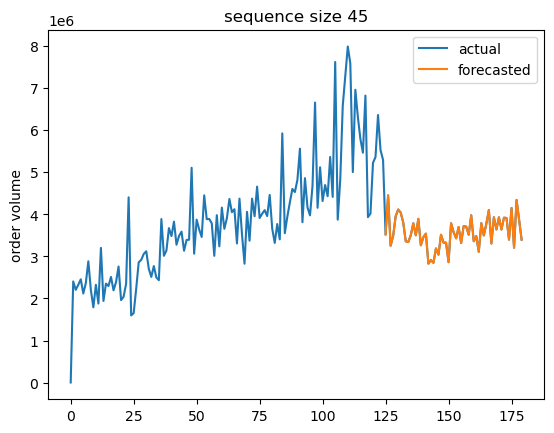

In [68]:
forecast=np.append(df4,f)
forecast=pd.DataFrame(forecast)
plt.plot()
plt.plot(pd.DataFrame(forecast),label='actual')
plt.plot(pd.DataFrame(forecast).loc[len(forecast)-forecast_size:],label='forecasted')
plt.ylabel('order volume')
plt.legend()
plt.title(f'sequence size {seq_size}')
plt.show()

Text(0.5, 1.0, 'sequence size 45')

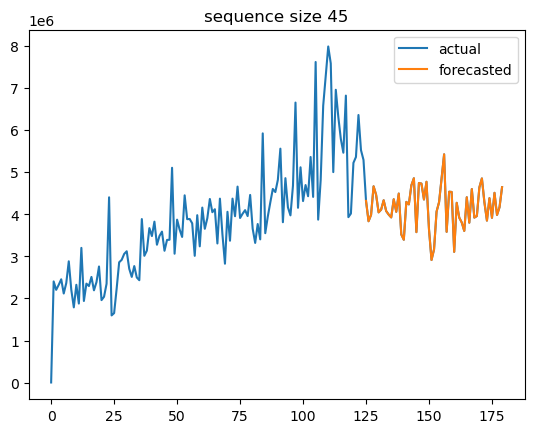

In [57]:
forecast=np.append(df4,f)
forecast=pd.DataFrame(forecast)
plt.plot()
plt.plot(pd.DataFrame(forecast),label='actual')
plt.plot(pd.DataFrame(forecast).loc[len(forecast)-forecast_size:],label='forecasted')
plt.legend()
plt.title(f'sequence size {seq_size}')

Text(0.5, 1.0, 'sequence size 45')

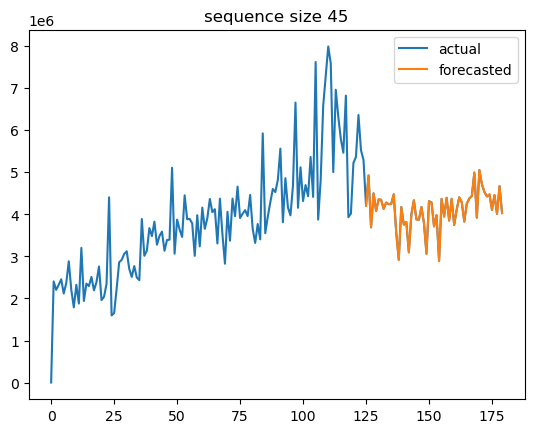

In [48]:
forecast=np.append(df4,f)
forecast=pd.DataFrame(forecast)
plt.plot()
plt.plot(pd.DataFrame(forecast),label='actual')
plt.plot(pd.DataFrame(forecast).loc[len(forecast)-forecast_size:],label='forecasted')
plt.legend()
plt.title(f'sequence size {seq_size}')

Text(0.5, 1.0, 'sequence size 45')

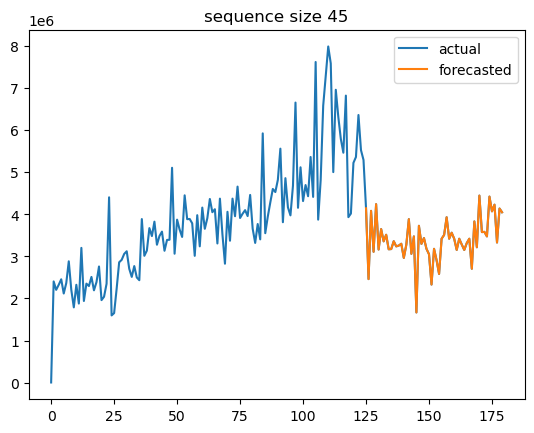

In [39]:
forecast=np.append(df4,f)
forecast=pd.DataFrame(forecast)
plt.plot()
plt.plot(pd.DataFrame(forecast),label='actual')
plt.plot(pd.DataFrame(forecast).loc[len(forecast)-forecast_size:],label='forecasted')
plt.legend()
plt.title(f'sequence size {seq_size}')

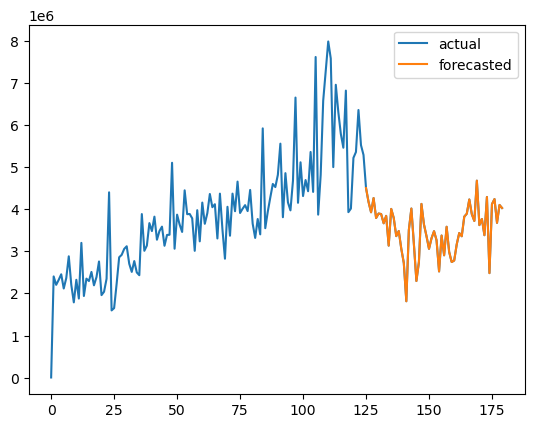

In [26]:
forecast=np.append(df4,f)
forecast=pd.DataFrame(forecast)
plt.plot()
plt.plot(pd.DataFrame(forecast),label='actual')
plt.plot(pd.DataFrame(forecast).loc[len(forecast)-forecast_size:],label='forecasted')
plt.legend()

Text(0.5, 1.0, 'sequence size 45')

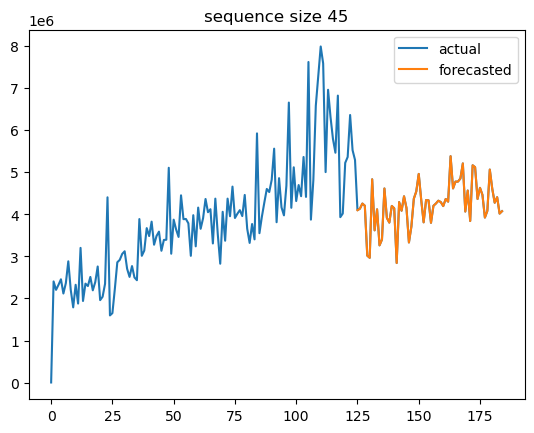

In [103]:
forecast=np.append(df4,f)
forecast=pd.DataFrame(forecast)
plt.plot()
plt.plot(pd.DataFrame(forecast),label='actual')
plt.plot(pd.DataFrame(forecast).loc[len(forecast)-forecast_size:],label='forecasted')
plt.legend()
plt.title(f'sequence size {seq_size}')

Text(0.5, 1.0, 'sequence size 50')

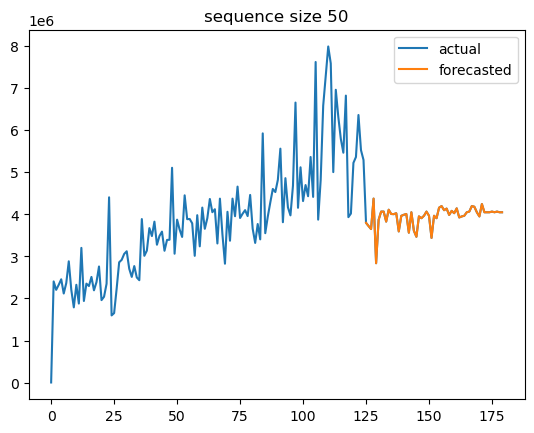

In [111]:
forecast=np.append(df4,f)
forecast=pd.DataFrame(forecast)
plt.plot()
plt.plot(pd.DataFrame(forecast),label='actual')
plt.plot(pd.DataFrame(forecast).loc[len(forecast)-forecast_size:],label='forecasted')
plt.legend()
plt.title(f'sequence size {seq_size}')

Text(0.5, 1.0, 'sequence size 46')

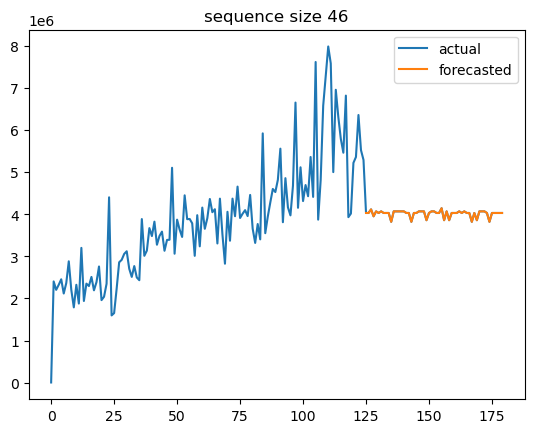

In [120]:
forecast=np.append(df4,f)
forecast=pd.DataFrame(forecast)
plt.plot()
plt.plot(pd.DataFrame(forecast),label='actual')
plt.plot(pd.DataFrame(forecast).loc[len(forecast)-forecast_size:],label='forecasted')
plt.legend()
plt.title(f'sequence size {seq_size}')

Text(0.5, 1.0, 'sequence size 40')

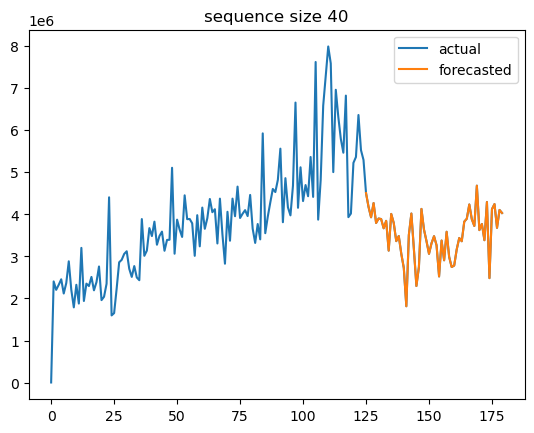

In [29]:
forecast=np.append(df4,f)
forecast=pd.DataFrame(forecast)
plt.plot()
plt.plot(pd.DataFrame(forecast),label='actual')
plt.plot(pd.DataFrame(forecast).loc[len(forecast)-forecast_size:],label='forecasted')
plt.legend()
plt.title(f'sequence size {seq_size}')

Text(0.5, 1.0, 'sequence size 45')

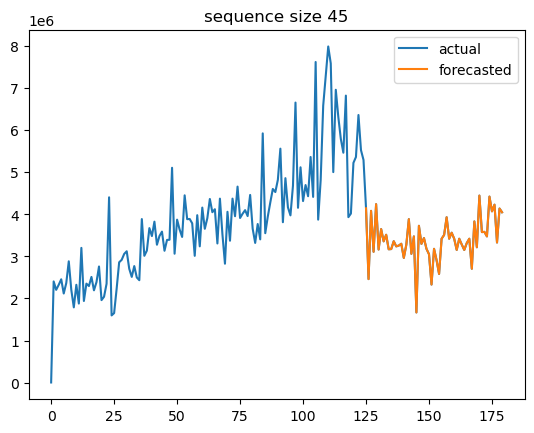

In [40]:
forecast=np.append(df4,f)
forecast=pd.DataFrame(forecast)
plt.plot()
plt.plot(pd.DataFrame(forecast),label='actual')
plt.plot(pd.DataFrame(forecast).loc[len(forecast)-forecast_size:],label='forecasted')
plt.legend()
plt.title(f'sequence size {seq_size}')